In [1]:
from sklearn.model_selection import train_test_split

from scripts.data_genertion.consts import *
from scripts.data_genertion.data_handling import populate_features, get_populate_fold
from scripts.features.feature_extraction import load_all_features

main_df = load_all_features()
main_df[SEQUENCE] = main_df[SEQUENCE].astype(str)

In [2]:
from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR

genes_u = ['HIF1A', 'APOL1', 'YAP1', 'SOD1', 'SNCA', 'IRF4', 'KRAS', 'KLKB1', 'SNHG14', 'DGAT2', 'IRF5', 'HTRA1',
           'MYH7', 'MALAT1', 'HSD17B13']
cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

In [3]:
from scripts.data_genertion.data_handling import get_populated_df_with_structure_features

main_df = get_populated_df_with_structure_features(main_df, genes_u, gene_to_data)

In [4]:
main_df[[SENSE_TYPE, 'sense_intron', 'sense_exon', 'sense_utr', SENSE_START, CANONICAL_GENE]]

,sense_type,sense_intron,sense_exon,sense_utr,sense_start,Canonical Gene Name
0,intron,1,0,0,41212,KRAS
1,intron,1,0,0,23686,KRAS
2,intron,1,0,0,43363,KRAS
3,intron,1,0,0,23680,KRAS
4,intron,1,0,0,41168,KRAS
...,...,...,...,...,...,...
34760,intron,1,0,0,7827,APOL1
34761,intron,1,0,0,8250,APOL1
34762,intron,1,0,0,8335,APOL1
34763,utr,0,1,1,13848,APOL1


In [5]:
main_df.loc[:, 'mrna_length'] = [len(gene_to_data[gene].full_mrna) for gene in main_df[CANONICAL_GENE]]
main_df['normalized_sense_start_from_end'] = main_df['sense_start_from_end'] / main_df['mrna_length']

In [6]:
from scripts.data_genertion.consts import *


class Features:
    def __init__(self, features):
        self.__all_features = features
        self.__organize()

    def __organize(self):
        self.hybridization = []
        self.sequence = []
        self.fold = []
        self.one_hot = []
        for feature in self.__all_features:
            if "dsm" in feature:
                self.hybridization.append(feature)
            if feature in ['md_ps_hybr_norm', 'md_ps_hybr', 'exp_ps_hybr', 'exp_ps_hybr_norm', 'melting_temperature_1',
                           'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600'
                           ]:
                self.hybridization.append(feature)
            # if feature in [SENSE_TYPE]:
            #     self.one_hot.append(feature)
            if feature in ['at_skew', 'gc_content', 'entropy', 'gc_skew',
                           'gc_content_3_prime_5', 'hairpin_score', 'homooligo_count', 'internal_fold',
                           'nucleotide_diversity', 'stop_codon_count', 'self_energy', 'at_rich_region_score',
                           'poly_pyrimidine_stretch', 'normalized_start', 'sense_exon', 'sense_intron', 'sense_utr']:
                self.sequence.append(feature)
            if 'on_target_fold' in feature or feature in ['mfe_edges_45', 'mfe_window_45']:
                self.fold.append(feature)

    def get_all(self):
        return self.hybridization + self.sequence + self.fold


main_df.columns

Index(['index', 'ASO_volume(nM)', 'Canonical Gene Name', 'Cell line organism',
       'Cell_line', 'Chemical_Pattern', 'Density(cells_per_well)', 'ISIS',
       'Inhibition(%)', 'Linkage', 'Linkage_Location', 'Location',
       'Location_div_by_length', 'Location_in_sequence', 'Modification',
       'Primer_probe_set', 'Sequence', 'Target_gene', 'Transcript',
       'Transfection', 'Treatment_Period(hours)', 'at_rich_region_score',
       'at_skew', 'cell_line_uniform',
       'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1382t37Trueon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1384t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1384t37Trueon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1386t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1386t37Trueon_target_energy_max600',
       'dsm_su95_rev_woGU_pos1382t37Falseon_target_energy_max600',
       'dsm_su95_rev_woGU_pos1382t37Trueon_target_energy_max600',

In [7]:
# populate_features(main_df, ['at_rich_region_score', 'poly_pyrimidine_stretch'])

In [8]:
# from scripts.features.feature_extraction import save_feature
#
# save_feature(main_df, 'at_rich_region_score')
# save_feature(main_df, 'sense_start_from_end')

In [9]:
import numpy as np
import pandas as pd

first_filtered = main_df.copy()

first_filtered = first_filtered[first_filtered['Cell line organism'] == 'human']
# filtered = filtered[filtered[CANONICAL_GENE] == 'MALAT1']
first_filtered = first_filtered.dropna(subset=[INHIBITION]).copy()
# filtered = filtered.dropna(subset=[DENSITY_UPDATED]).copy()
log_correction = 1.001
first_filtered.loc[:, 'log_inhibition'] = -np.log(log_correction - first_filtered[INHIBITION] / 100)
first_filtered = first_filtered[~first_filtered[CELL_LINE].isin([
    'Hela',  # scanning modifications
    'Human Neuronal Cell',  # scanning modifications;
    'CC-2580',  # scanning modifications
    'SH-SY5Y'  # non pure PS based
])]
# first_filtered = first_filtered[~((first_filtered[CELL_LINE] == 'A431')
#                                   & (first_filtered[CANONICAL_GENE] == 'SOD1'))] # (Kind of) Scanning modifications

mean_metric = 'log_inhibition'
# mean_metric = INHIBITION

# Ensure you remove only the columns you don't want to group by
# cols_except_inhibition = [c for c in first_filtered.columns
#                           if c not in [INHIBITION, mean_metric, 'index']]

# Group by all remaining columns and average log_inhibition
collapsed = (
    first_filtered
    .groupby(['ISIS', VOLUME, TREATMENT_PERIOD, DENSITY_UPDATED, CHEMICAL_PATTERN], as_index=False)[mean_metric]
    .mean()
)

# first_filtered['mean_inhibition'] = first_filtered.groupby('ISIS')[mean_metric].transform('mean')
# first_filtered = first_filtered.drop_duplicates(subset='ISIS').assign(**{mean_metric: first_filtered['mean_inhibition']}).drop(
#     columns='mean_inhibition')

In [10]:
collapsed

,ISIS,ASO_volume(nM),Treatment_Period(hours),Density(cells_per_well),Chemical_Pattern,log_inhibition
0,76577.0,4000.0,48.0,10000.0,CCCddddddddddCCC,0.476424
1,146143.0,187.5,16.0,20000.0,MMMMMddddddddddMMMMM,0.060812
2,146143.0,750.0,16.0,20000.0,MMMMMddddddddddMMMMM,0.126698
3,146143.0,3000.0,16.0,20000.0,MMMMMddddddddddMMMMM,0.711311
4,146143.0,4000.0,24.0,20000.0,MMMMMddddddddddMMMMM,0.731888
...,...,...,...,...,...,...
23189,70001072.0,5000.0,96.0,15000.0,LLLdddddddddLLLL,1.382302
23190,70001081.0,5000.0,96.0,2000.0,LLLLdddddddddLLLL,1.136314
23191,70001101.0,5000.0,96.0,15000.0,LLLddddddddddLLL,1.422958
23192,70001102.0,5000.0,96.0,15000.0,LLLdddddddddLLLL,1.305636


In [11]:
import numpy as np


def log_inhibition_to_regular(log_inhibition):
    return 100 * (-np.exp(-log_inhibition) + log_correction)


In [12]:
# filtered = filtered[filtered['Linkage'] == 'phosphorothioate']

moe_pattern = 'MMMMMddddddddddMMMMM'
# filtered = filtered[filtered['Chemical_Pattern'] == moe_pattern].copy()
# filtered = filtered[filtered[VOLUME] == 2500].copy()
filtered = first_filtered.copy()

filtered['log_volume'] = np.log(filtered[VOLUME])
filtered['log_treatment'] = np.log(filtered[TREATMENT_PERIOD])
li = filtered['log_inhibition']

# filtered['correct_log_inhibition'] = filtered['log_inhibition'] / (filtered['log_volume'])
filtered['correct_log_inhibition'] = li / (filtered[VOLUME] / (filtered[VOLUME] + 10))
# filtered['correct_log_inhibition'] = li


features_obj = Features(filtered.columns)
features_obj.hybridization = ['exp_ps_hybr']
features_obj.fold = ['on_target_fold_openness_normalized40_15']
# features_obj.fold = []
features = features_obj.get_all()
# features = features_obj.hybridization + features_obj.fold
epi_features = [
    TREATMENT_PERIOD,
    # 'log_volume',
    # DENSITY_UPDATED
]
print(features_obj.one_hot)
for feature in features_obj.one_hot:
    filtered = pd.get_dummies(filtered, columns=[feature]).copy()

one_hot_features = []
for one_hot_feature in features_obj.one_hot:
    one_hot_features.append(
        [feature for feature in filtered.columns if one_hot_feature in feature and one_hot_feature != feature])
flat_one_hot_encoded_features = [feature for sublist in one_hot_features for feature in sublist]
# features = epi_features
features = epi_features + features + flat_one_hot_encoded_features


[]


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRanker

seed = 42

train, test = train_test_split(filtered, test_size=0.2, random_state=seed)
train['group_key'] = train[CELL_LINE].astype(str)
# train['group_key'] = train[CELL_LINE].astype(str) + '_' + train[CANONICAL_GENE].astype(str)
train = train.sort_values('group_key')
group_train = train.groupby('group_key').size().tolist()

# metric = 'correct_log_inhibition'
# metric = 'log_inhibition'
metric = INHIBITION

print("Test: ", len(test))
print("Train: ", len(train))
X = train[features]
# y = train.groupby(CELL_LINE)[metric].rank(method='dense', ascending=True).astype(int)
y = train[metric]

model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk", seed=seed)
# model = XGBRanker(objective='rank:pairwise')
model.fit(X.to_numpy(), y.to_numpy(), group=group_train)
# model = LinearRegression()
# model.fit(X.to_numpy(), y.to_numpy())



Test:  5205
Train:  20820


,objective,'rank:ndcg'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


cell-line:A431, length:6541  A431
Inhibition(%)
gene-KRAS length: 925
P:0.27, p-value: 2.1e-17
S:0.26 , p-value: 2.8e-15
gene-MALAT1 length: 3053
P:0.3, p-value: 5.3e-66
S:0.3 , p-value: 9.6e-65
gene-SOD1 length: 429
P:0.37, p-value: 2.2e-15
S:0.39 , p-value: 5.6e-17
gene-APOL1 length: 2134
P:0.17, p-value: 1.2e-14
S:0.18 , p-value: 1e-16
cell-line:NCI-H460, length:18  NCI-H460
Inhibition(%)
gene-KRAS length: 18
P:0.69, p-value: 0.0015
S:0.74 , p-value: 0.00047
cell-line:Human IPS, length:24  Human IPS
Inhibition(%)
gene-SNCA length: 24
P:0.63, p-value: 0.0011
S:0.76 , p-value: 1.5e-05
cell-line:KARPAS-229, length:972  KARPAS-229
Inhibition(%)
gene-IRF5 length: 972
P:0.64, p-value: 9.3e-114
S:0.62 , p-value: 2.1e-102
cell-line:A-431, length:126  A-431
Inhibition(%)
gene-IRF5 length: 126
P:0.4, p-value: 3.8e-06
S:0.36 , p-value: 3.4e-05
cell-line:MM.1R, length:3394  MM.1R
Inhibition(%)
gene-IRF4 length: 3394
P:0.52, p-value: 2.2e-233
S:0.58 , p-value: 3.7e-304
cell-line:SK-MEL-28, lengt

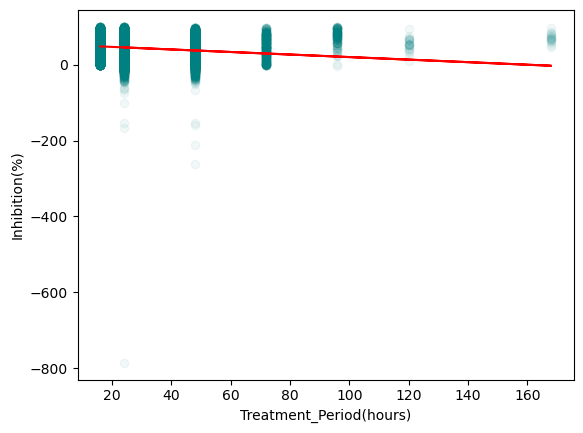

Inhibition(%)
Feature:  exp_ps_hybr
P:-0.08 p-value 1.7e-38
S:-0.047 p-value 2.7e-14


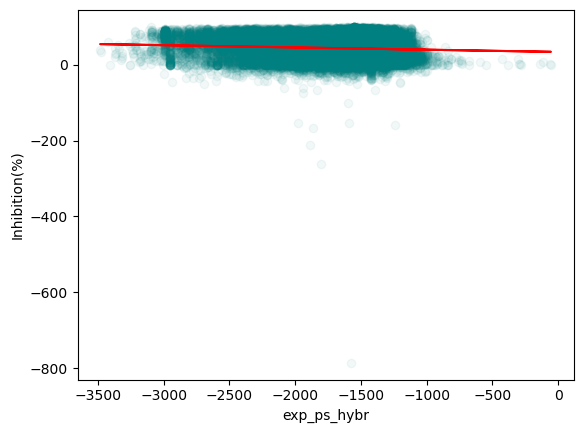

Inhibition(%)
Feature:  at_rich_region_score
P:0.0094 p-value 0.13
S:-0.0033 p-value 0.6


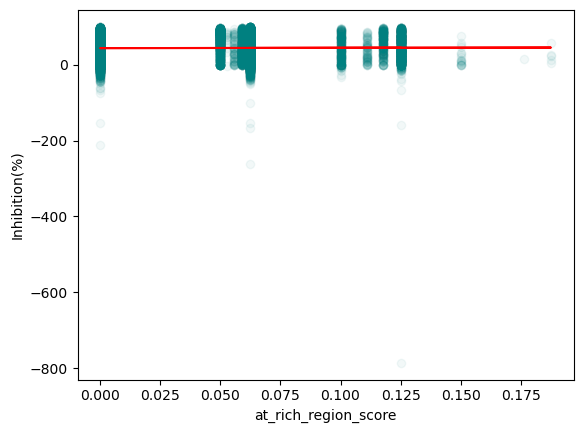

Inhibition(%)
Feature:  at_skew
P:-0.16 p-value 4.1e-150
S:-0.16 p-value 3.5e-141


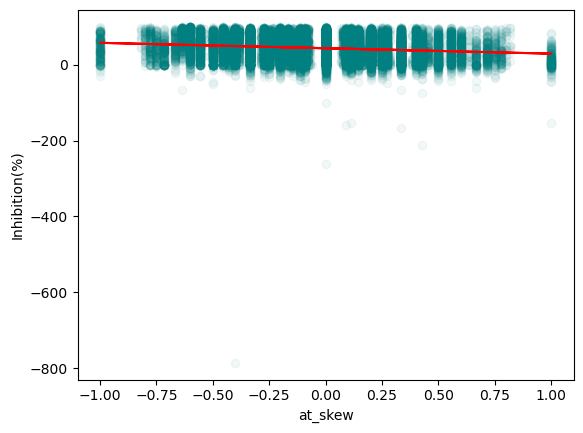

Inhibition(%)
Feature:  entropy
P:0.044 p-value 1.1e-12
S:0.045 p-value 2.8e-13


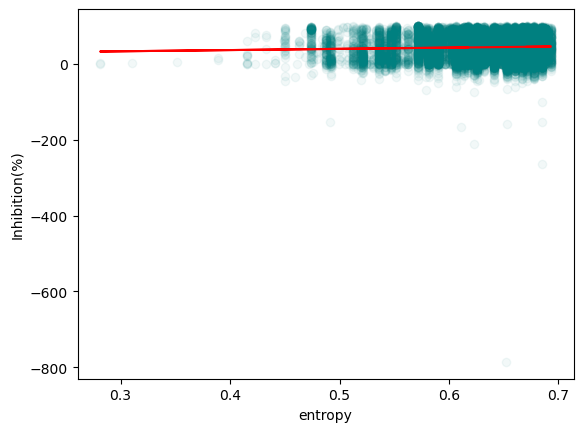

Inhibition(%)
Feature:  gc_content
P:-0.07 p-value 2.2e-29
S:-0.052 p-value 2.9e-17


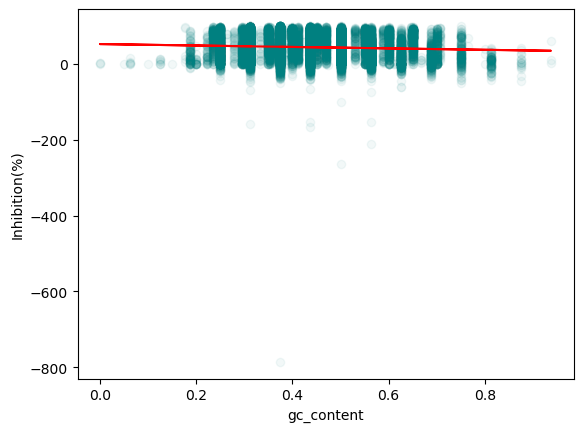

Inhibition(%)
Feature:  gc_content_3_prime_5
P:-0.019 p-value 0.0024
S:-0.014 p-value 0.027


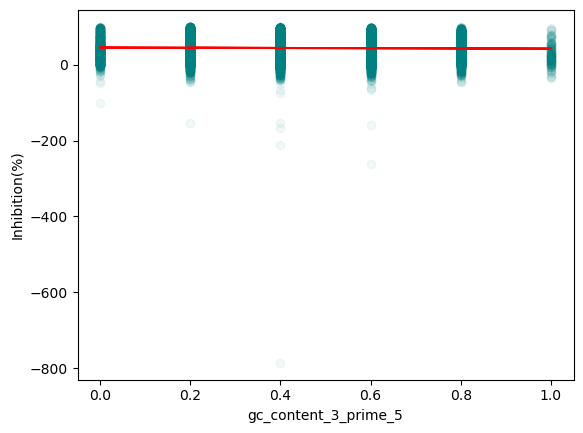

Inhibition(%)
Feature:  gc_skew
P:0.11 p-value 1.1e-69
S:0.1 p-value 2.4e-59


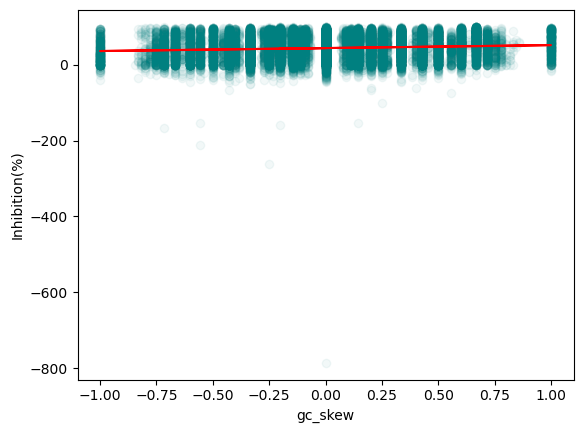

Inhibition(%)
Feature:  hairpin_score
P:-0.037 p-value 2e-09
S:-0.021 p-value 0.00062


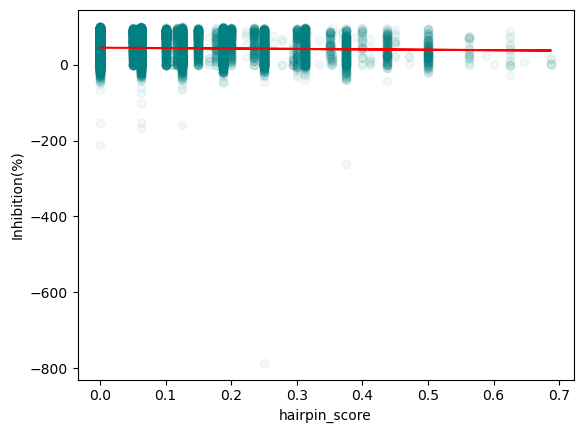

Inhibition(%)
Feature:  homooligo_count
P:-0.015 p-value 0.019
S:-0.014 p-value 0.022


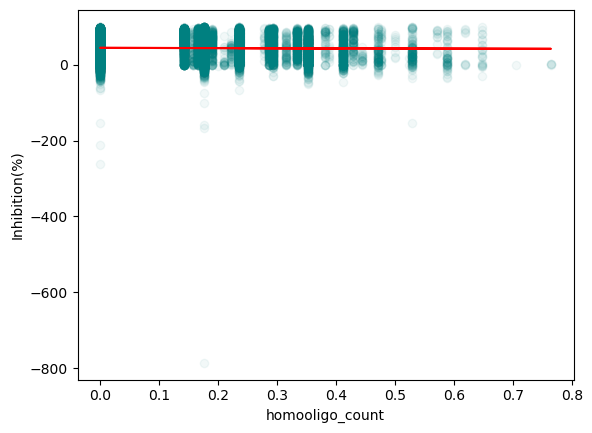

Inhibition(%)
Feature:  internal_fold
P:-0.0021 p-value 0.73
S:0.002 p-value 0.75


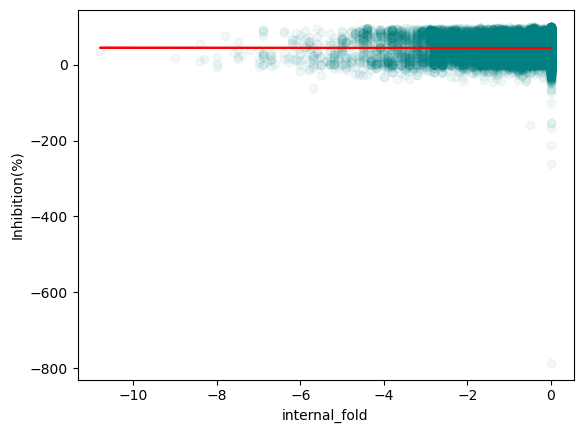

Inhibition(%)
Feature:  normalized_start
P:0.14 p-value 4.4e-108
S:0.14 p-value 5.1e-109


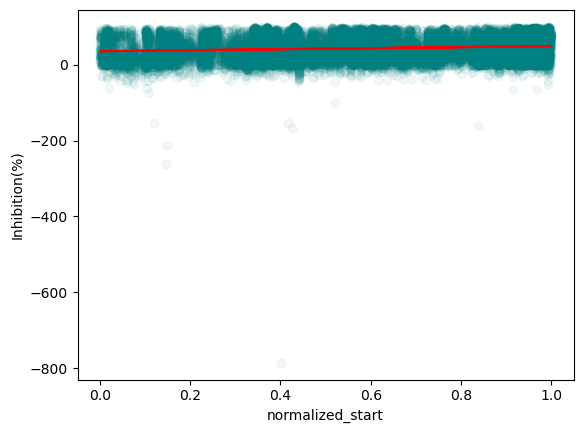

Inhibition(%)
Feature:  nucleotide_diversity
P:0.097 p-value 8.9e-56
S:0.09 p-value 2.2e-48


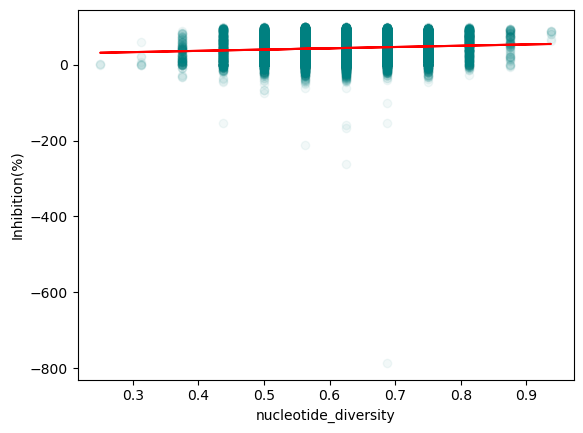

Inhibition(%)
Feature:  poly_pyrimidine_stretch
P:0.038 p-value 1.3e-09
S:0.018 p-value 0.0042


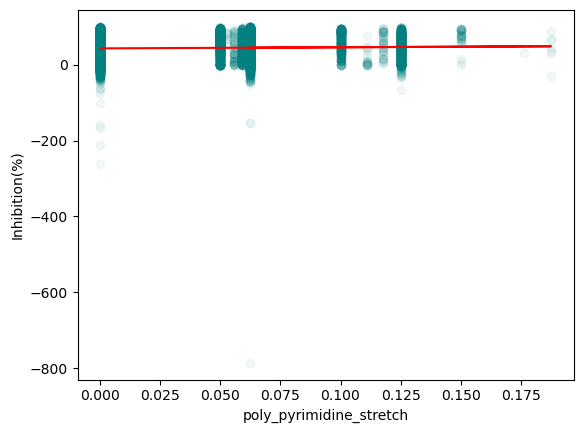

Inhibition(%)
Feature:  self_energy
P:0.021 p-value 0.00054
S:0.014 p-value 0.029


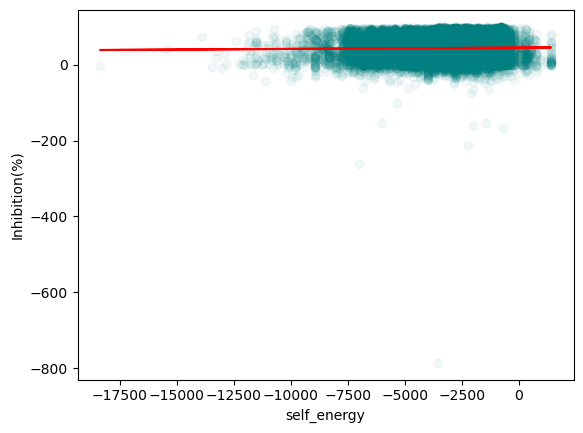

Inhibition(%)
Feature:  stop_codon_count
P:-0.016 p-value 0.0078
S:-0.032 p-value 2.2e-07


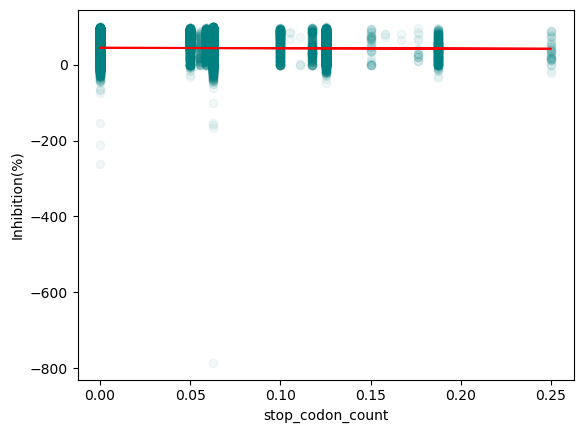

Inhibition(%)
Feature:  sense_exon
P:-0.008 p-value 0.2
S:-0.011 p-value 0.09


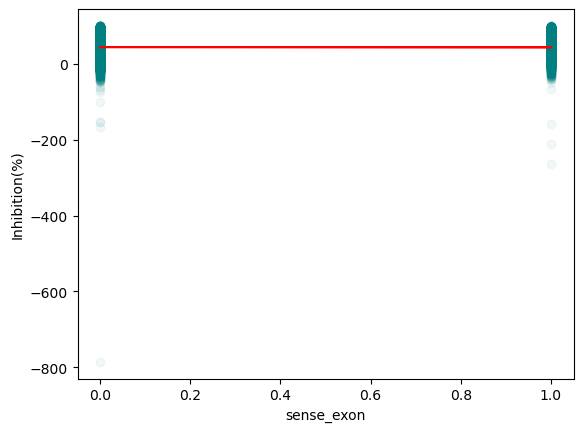

Inhibition(%)
Feature:  sense_intron
P:-0.015 p-value 0.015
S:-0.013 p-value 0.034


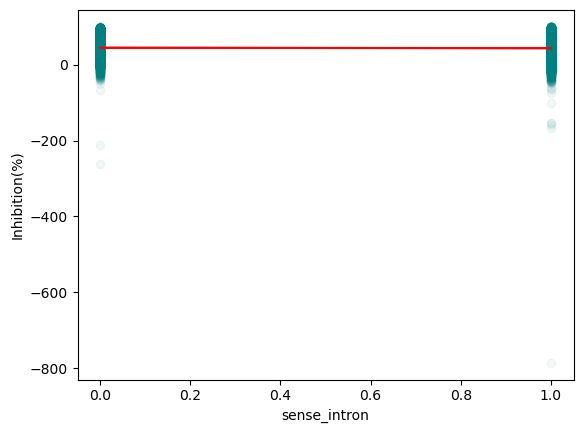

Inhibition(%)
Feature:  sense_utr
P:0.09 p-value 4.8e-48
S:0.089 p-value 1.4e-46


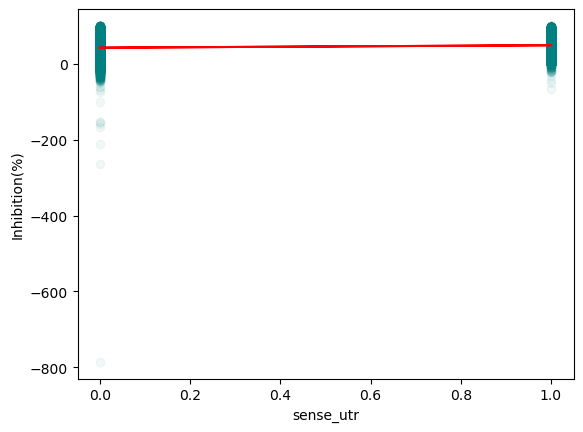

Inhibition(%)
Feature:  on_target_fold_openness_normalized40_15
P:0.22 p-value 2e-271
S:0.19 p-value 7.6e-216


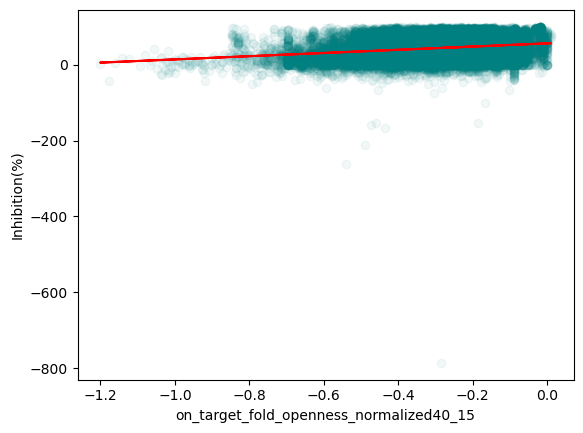

P:  0.4779924444139708
S:  0.47748804420295926
PTRAIN:  0.4835026840055346
PTEST:  0.4552240671647469
STRAIN:  0.484516161045719
STEST:  0.44952604247812256
PvaluePtest:  1.042803659816167e-264
PValueStest:  2.2229665233796526e-257


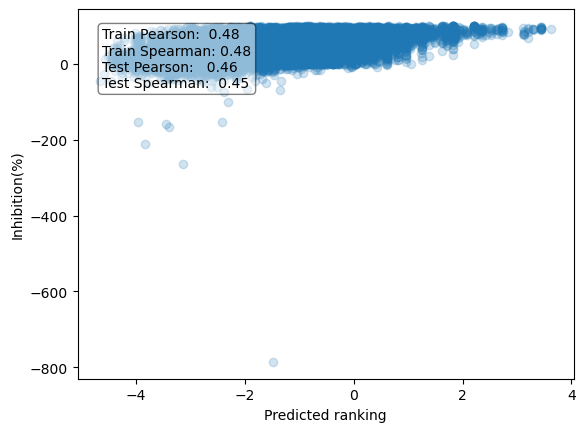

In [14]:
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr

train_filtered = train.copy()
test_filtered = test.copy()

# train_filtered = train.nlargest(200, metric)
# test_filtered = test.nlargest(200, metric)

train_pred = model.predict(train_filtered[features].to_numpy())
test_pred = model.predict(test_filtered[features].to_numpy())

y_test = test_filtered[metric].to_numpy()
y_train = train_filtered[metric].to_numpy()

cell_lines = filtered[CELL_LINE].unique()
# for cell_line in cell_lines:
for cell_line in cell_lines:
    cell_line_mask = filtered[CELL_LINE] == cell_line
    print(f"cell-line:{cell_line}, length:{cell_line_mask.sum()} ", cell_line)
    print(metric)

    for gene in filtered[cell_line_mask][CANONICAL_GENE].unique():
        hepa_mask = cell_line_mask & (filtered[CANONICAL_GENE] == gene)
        print(f"gene-{gene} length: {hepa_mask.sum()}")
        # for f in ['sense_exon', 'sense_intron', 'sense_utr']:
        for f in ['NA']:
            # hep_pred = filtered[hepa_mask][f].to_numpy()
            # print(f"{f}: {filtered[hepa_mask][f].sum()} / {hepa_mask.sum()}")
            hep_pred = model.predict(filtered[hepa_mask][features].to_numpy())
            hepa_truth = filtered[hepa_mask][metric]
            p_hepa, pp_value = pearsonr(hepa_truth, hep_pred)
            s_hepa, sp_value = spearmanr(hepa_truth, hep_pred)
            print(f"P:{p_hepa:.2}, p-value: {pp_value:.2}")
            print(f"S:{s_hepa:.2} , p-value: {sp_value:.2}")

for feature in features:
    # EXAMPLE = 'GGCATATGCAGATAATGTTC'

    # malat_mask = filtered[CELL_LINE] == 'U251'

    # malat_mask = filtered[CANONICAL_GENE] == "HSD17B13"
    # malat_mask = filtered[CANONICAL_GENE] == "MALAT1"
    malat_mask = filtered[CANONICAL_GENE] != "AAA"
    # example_mask = (filtered[CANONICAL_GENE] == "MALAT1") & (filtered[SEQUENCE] == EXAMPLE)
    malat_pred = model.predict(filtered[malat_mask][features].to_numpy())
    print(metric)
    malat_truth = filtered[malat_mask][metric]
    p_hepa, pp_value = pearsonr(malat_truth, filtered[malat_mask][feature])
    s_hepa, sp_value = spearmanr(malat_truth, filtered[malat_mask][feature])

    # plt.scatter(filtered[malat_mask][feature], malat_truth)
    # example_df = filtered.loc[example_mask, :].copy()
    # plt.scatter(example_df[feature], malat_truth[example_mask], color='orange')
    plt.scatter(filtered[malat_mask][feature], malat_truth, color='teal', alpha=0.05)
    m, b = np.polyfit(filtered[malat_mask][feature], malat_truth, 1)
    plt.plot(filtered[malat_mask][feature], m*filtered[malat_mask][feature] + b, color='red')
    plt.xlabel(feature)
    plt.ylabel(metric)
    print("Feature: ", feature)
    print(f"P:{p_hepa:.2} p-value {pp_value:.2}")
    print(f"S:{s_hepa:.2} p-value {sp_value:.2}")
    plt.show()

p_hepa, _ = pearsonr(malat_truth, malat_pred)
s_hepa, _ = spearmanr(malat_truth, malat_pred)
print("P: ", p_hepa)
print("S: ", s_hepa)

p_train, _ = pearsonr(y_train, train_pred)
s_train, _ = spearmanr(y_train, train_pred)
p_test, p_value_ptest = pearsonr(y_test, test_pred)
s_test, p_value_stest = spearmanr(y_test, test_pred)

print("PTRAIN: ", p_train)
print("PTEST: ", p_test)
print("STRAIN: ", s_train)
print("STEST: ", s_test)
print("PvaluePtest: ", p_value_ptest)
print("PValueStest: ", p_value_stest)

# scatter plot
# plt.scatter(test_pred, y_test, alpha=0.2)
plt.scatter(malat_pred, malat_truth, alpha=0.2)

# least‑squares regression line
# slope, intercept = np.polyfit(test_pred, y_test, 1)
# x = np.linspace(test_pred.min(), test_pred.max(), 100)
# plt.plot(x, slope * x + intercept, color='red')

# labels and stats
plt.xlabel('Predicted ranking')
plt.ylabel(metric)
txt = (
    f"Train Pearson:  {p_train:.2f}\n"
    f"Train Spearman: {s_train:.2f}\n"
    f"Test Pearson:   {p_test:.2f}\n"
    f"Test Spearman:  {s_test:.2f}"
)
plt.text(
    0.05, 0.95, txt,
    transform=plt.gca().transAxes,
    va='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

plt.show()


In [15]:
def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean())

In [16]:
def get_threshold_for_percentile(percentile, df):
    k = max(1, int(np.ceil((percentile / 100) * len(df))))  # desired count
    threshold = np.partition(df, -k)[-k]  # value at 99th percentile
    return threshold


# def correction(df):
#     return (df['log_volume'])

# def correction(df):
#     return (df[VOLUME]) / df[VOLUME]

def correction(df):
    return df[VOLUME] / (df[VOLUME] + 10)


#

for percentile in [1, 5, 10, 50]:
    threshold = get_threshold_for_percentile(percentile, log_inhibition_to_regular(filtered['log_inhibition']))
    # print(correction(filtered))
    # print(log_inhibition_to_regular(filtered['log_inhibition']))
    print(f"Threshold for top_{percentile}: {threshold}")

Threshold for top_1: 96.0
Threshold for top_5: 90.0
Threshold for top_10: 85.0
Threshold for top_50: 43.99999999999999


Mean model:  100.09999999999998
Mean best:  100.09999999999998
Mean random:  -1488.080976093783


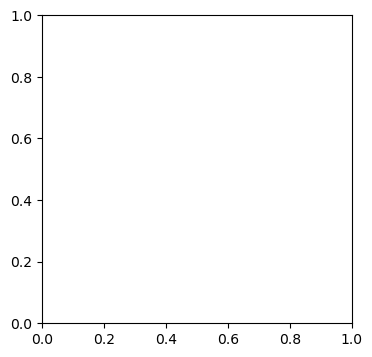

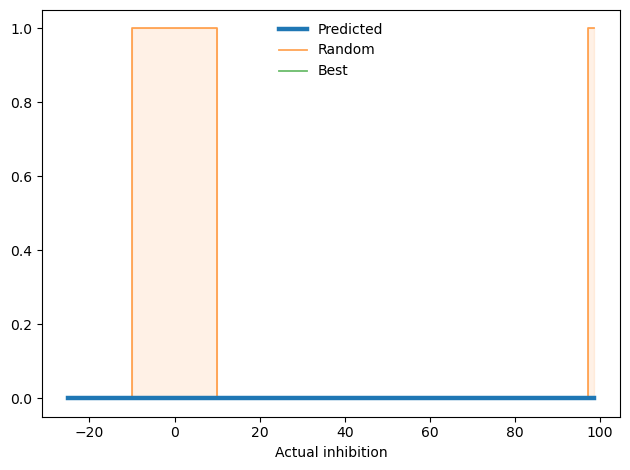

In [17]:
percentile = 0.5

train_threshold = get_threshold_for_percentile(percentile, train_pred)
test_threshold = get_threshold_for_percentile(percentile, test_pred)

test_mask = test_pred > test_threshold

top_k = test_mask.sum()

train_mask = train_pred > train_threshold

top_predicted_train = train_pred[train_mask]

top_train = log_inhibition_to_regular(y_train[train_mask] * correction(train_filtered[train_mask]))

top_predicted_test = test_pred[test_mask]
top_test = log_inhibition_to_regular(y_test[test_mask] * correction(test_filtered[test_mask]))

# k already computed as the desired sample size
rand_mask = np.zeros(len(y_test), dtype=bool)
rand_mask[np.random.choice(len(y_test), top_k, replace=False)] = True

# ---------- best possible ----------
all_inhib = log_inhibition_to_regular(y_test * correction(test_filtered))
top_best = all_inhib.nlargest(top_k).to_numpy()  # no index confusion

# random sample via mask
rand_perm = y_test[rand_mask]
top_rand_test = log_inhibition_to_regular(y_test[rand_mask] * correction(test_filtered[rand_mask]))

fig, ax = plt.subplots(figsize=(4, 4))
# ax.boxplot([top_test, top_rand_test],
#            tick_labels=['Top‑predicted', 'Random baseline']
#            )
print("Mean model: ", np.mean(top_test))
print("Mean best: ", np.mean(top_best))
print("Mean random: ", np.mean(top_rand_test))

# print("Mean model: ", geo_mean_overflow(top_test))
# print("Mean best: ", geo_mean_overflow(top_best))
# print("Mean random: ", geo_mean_overflow(top_rand_test))
bins = np.array([-50, 0, 10, 20, 30, 40, 50, 60, 70, 80, 85, 90, 95, 97, 100])
x = (bins[:-1] + bins[1:]) / 2

fig, ax = plt.subplots()

# --- Predicted: thick line, darker fill ---------------------------------
h_pred, _ = np.histogram(top_test, bins=bins)
ax.plot(x, h_pred, drawstyle='steps-mid', lw=3.2, color='C0',
        label='Predicted', zorder=5)
ax.fill_between(x, 0, h_pred, step='mid', alpha=0.35, color='C0', zorder=4)

# --- Others: thinner, lighter -------------------------------------------
for arr, lab, c in [(top_rand_test, 'Random', 'C1'),
                    (top_best, 'Best', 'C2')]:
    h, _ = np.histogram(arr, bins=bins)
    ax.plot(x, h, drawstyle='steps-mid', lw=1.3, color=c, alpha=0.7, label=lab, zorder=3)
    ax.fill_between(x, 0, h, step='mid', alpha=0.10, color=c, zorder=2)

# ax.set_yscale('log')        # drop if you don't want log
ax.set_xlabel('Actual inhibition')
ax.legend(frameon=False)
fig.tight_layout()
plt.show()



In [18]:
MALAT_scores = model.predict(filtered[filtered[CANONICAL_GENE] == 'MALAT1'][features])
MALAT_scores.sort()
print(MALAT_scores)
get_threshold_for_percentile(1, MALAT_scores)

[-4.6579685  -4.5830317  -4.5618153  ... -0.50282484 -0.23502077
 -0.23502077]


-1.1144979

In [19]:
# ---------------------------------------------------------------------------
# 5-fold “stable” permutation-importance for an XGBRanker (rank:pairwise)
# – one query = all rows that share the same CELL_LINE ----------------------
# ---------------------------------------------------------------------------

from xgboost import XGBRanker
from sklearn.model_selection import GroupKFold
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from scipy import stats
import numpy as np
import pandas as pd

metric = "correct_log_inhibition"  # target column
groups = filtered[CELL_LINE]  # one “qid” per row
gkf = GroupKFold(n_splits=6)


def spearman_scorer(est, X, y):  # (estimator, X, y) signature
    return stats.spearmanr(y, est.predict(X)).correlation ** 2


all_imps = []

for tr_idx, te_idx in gkf.split(filtered, filtered[metric], groups):
    # ---- build train / test sets -----------------------------------------
    train_df = filtered.iloc[tr_idx].sort_values(CELL_LINE)  # keep queries contiguous
    test_df = filtered.iloc[te_idx]

    X_tr, y_tr = train_df[features], train_df[metric]
    X_te, y_te = test_df[features], test_df[metric]

    group_train = train_df.groupby(CELL_LINE).size().tolist()  # sizes per query

    # ---- fit a fresh ranker on this fold ---------------------------------
    ranker = XGBRanker(objective="rank:pairwise", random_state=42)
    ranker.fit(X_tr.to_numpy(), y_tr.to_numpy(), group=group_train)

    # ---- permutation importance on the hold-out --------------------------
    r = permutation_importance(
        ranker, X_te.to_numpy(), y_te.to_numpy(),
        n_repeats=30, scoring=spearman_scorer,
        random_state=42, n_jobs=1
    )
    all_imps.append(r.importances_mean)

# --------------------------------------------------------------------------
# aggregate across folds
imp_mat = np.vstack(all_imps)  # (folds × features)
imp_df = pd.DataFrame(
    imp_mat.T,
    index=features,
    columns=[f"fold_{i + 1}" for i in range(imp_mat.shape[0])]
)

summary = (imp_df
           .agg(["mean", "std"], axis=1)
           .rename(columns={"mean": "mean_imp", "std": "std_imp"})
           .sort_values("mean_imp", ascending=False))


In [20]:
print(summary.head(15))


                                         mean_imp   std_imp
on_target_fold_openness_normalized40_15  0.020712  0.033100
at_skew                                  0.020706  0.032743
gc_content                               0.007670  0.016868
exp_ps_hybr                              0.005167  0.015082
sense_utr                                0.002835  0.006207
stop_codon_count                         0.002612  0.003905
hairpin_score                            0.002535  0.004574
homooligo_count                          0.002003  0.003493
gc_skew                                  0.001917  0.007251
self_energy                              0.000737  0.003026
entropy                                  0.000612  0.004667
Treatment_Period(hours)                  0.000478  0.007340
sense_intron                             0.000273  0.004006
poly_pyrimidine_stretch                  0.000246  0.001945
gc_content_3_prime_5                     0.000017  0.000324


In [21]:

GFP_IN_YEAST = (
    'ATGGTtAGtAAaGGaGAaGAGTTgTTCACaGGaGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGGTGCTGGGGCAggtacCCCTAAAGATCCAGCCAAACCTCCGGCCAcGGCACAAGTTGTGGGATGGCCACCGGTGAGATCATACCGGAAGAACGTGATGGTTTCCTGCCAAAAATCAAGCGGTGGCCCGGAGGCGGCGGCGTTCGTGAAGTAA'
    .upper())
GFP_IN_HUMAN = (
    "atggtgagcaagggcgaggagctgttcaccggggtggtgcccatcctggtcgagctggacggcgacgtaaacggccacaagttcagcgtgtccggcgagggcgagggcgatgccacctacggcaagctgaccctgaagttcatctgcaccaccggcaagctgcccgtgccctggcccaccctcgtgaccaccctgacctacggcgtgcagtgcttcagccgctaccccgaccacatgaagcagcacgacttcttcaagtccgccatgcccgaaggctacgtccaggagcgcaccatcttcttcaaggacgacggcaactacaagacccgcgccgaggtgaagttcgagggcgacaccctggtgaaccgcatcgagctgaagggcatcgacttcaaggaggacggcaacatcctggggcacaagctggagtacaactacaacagccacaacgtctatatcatggccgacaagcagaagaacggcatcaaggtgaacttcaagatccgccacaacatcgaggacggcagcgtgcagctcgccgaccactaccagcagaacacccccatcggcgacggccccgtgctgctgcccgacaaccactacctgagcacccagtccgccctgagcaaagaccccaacgagaagcgcgatcacatggtcctgctggagttcgtgaccgccgccgggatcactctcggcatggacgagctgtacaagaagcttagccatggcttcccgccggaggtggaggagcaggatgatggcacgctgcccatgtcttgtgcccaggagagcgggatggaccgtcaccctgcagcctgtgcttctgctaggatcaatgtgaagcgacctgccgccacaaagaaggctggacaggctaagaagaagaaatgaggatcccgcgcgcgcatatgttaattaaccaactgcatggggatccacgcgttaagtcgacaatcaacctctggattacaaaatttgtgaaagattgactggtattcttaactatgttgctccttttacgctatgtggatacgctgctttaatgcctttgtatcatgctattgcttcccgtatggctttcattttctcctccttgtataaatcctggttgctgtctctttatgaggagttgtggcccgttgtcaggcaacgtggcgtggtgtgcactgtgtttgctgacgcaacccccactggttggggcattgccaccacctgtcagctcctttccgggactttcgctttccccctccctattgccacggcggaactcatcgccgcctgccttgcccgctgctggacaggggctcggctgttgggcactgacaattccgtggtgttgtcggggaaatcatcgtcctttccttggctgctcgcctgtgttgccacctggattctgcgcgggacgtccttctgctacgtcccttcggccctcaatccagcggaccttccttcccgcggcctgctgccggctctgcggcctcttccgcgtcttcgccttcgccctcagacgagtcggatctccctttgggccgcctccccgcgtcgactttaagaccaatgacttacaaggcagctgtagatcttagccactttttaaaagaaaaggggggactggaagggctaattcactcccaacgaagacaagatctgctttttgcttgtactgggtctctctggttagaccagatctgagcctgggagctctctggctaactagggaacccactgcttaagcctcaataaagcttgccttgagtgcttcaagtagtgtgtgcccgtctgttgtgtgactctggtaactagagatccctcagacccttttagtcagtgtggaaaatctctagcagtacgtatagtagttcatgtcatcttattattcagtatttataacttgcaaagaaatgaatatcagagagtgagagg".upper()
)
# GFP + Degron x <= 842
# NLS 843 <= x<= 893
# 3UTR 1615 <= x <= 1848


In [22]:
from scripts.data_genertion.data_handling import get_unique_human_genes

from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR

cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=['MALAT1'])
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

MALAT = gene_to_data['MALAT1'].full_mrna

In [23]:
from asodesigner.util import get_antisense
import pandas as pd

GFP_YEAST_END = len(GFP_IN_YEAST) - 3
GFP_HUMAN_END = 891  # TGA stop codon in NLS
malat_info = gene_to_data['MALAT1']
MALAT_END = malat_info.exon_indices[-1][1] - malat_info.cds_start

ASO_SIZE = 16

def get_init_df(target_mrna, end):
    candidates = []
    sense_starts = []
    sense_lengths = []
    sense_starts_from_end = []

    for i in range(0, len(target_mrna) - (ASO_SIZE - 1)):
        target = target_mrna[i: i + ASO_SIZE]
        candidates.append(get_antisense(str(target)))
        sense_starts.append(i)
        sense_lengths.append(ASO_SIZE)
        sense_starts_from_end.append(end - i)
    df = pd.DataFrame(
        {SEQUENCE: candidates, SENSE_START: sense_starts,
         SENSE_LENGTH: sense_lengths, "sense_start_from_end": sense_starts_from_end})
    return df


SEQUENCES = [GFP_IN_YEAST, GFP_IN_HUMAN, MALAT]
df_yeast = get_init_df(GFP_IN_YEAST, GFP_YEAST_END)
df_human = get_init_df(GFP_IN_HUMAN, GFP_HUMAN_END)
df_malat = get_init_df(MALAT, MALAT_END)

In [24]:
df_yeast[CANONICAL_GENE] = 'YEAST_GFP'
df_human[CANONICAL_GENE] = 'HUMAN_GFP'
df_malat[CANONICAL_GENE] = 'MALAT1'
dataframes = [df_yeast, df_human, df_malat]

In [25]:
for df in dataframes:
    df[CELL_LINE_ORGANISM] = 'human'
    df[INHIBITION] = 0 # Just for the function, not important

In [26]:
df_malat = get_populated_df_with_structure_features(df_malat, ['MALAT1'], gene_to_data)
dataframes[2] = df_malat
df_malat

,Sequence,sense_start,sense_length,sense_start_from_end,Canonical Gene Name,Cell line organism,Inhibition(%),sense_exon,sense_intron,sense_utr,sense_type
0,CCGGTGGGGCTGCGTC,0,16,8829,MALAT1,human,0,1,0,0,exon
1,ACCGGTGGGGCTGCGT,1,16,8828,MALAT1,human,0,1,0,0,exon
2,AACCGGTGGGGCTGCG,2,16,8827,MALAT1,human,0,1,0,0,exon
3,CAACCGGTGGGGCTGC,3,16,8826,MALAT1,human,0,1,0,0,exon
4,GCAACCGGTGGGGCTG,4,16,8825,MALAT1,human,0,1,0,0,exon
...,...,...,...,...,...,...,...,...,...,...,...
8809,TTCCCCAATCAAGATT,8809,16,20,MALAT1,human,0,1,0,0,exon
8810,TTTCCCCAATCAAGAT,8810,16,19,MALAT1,human,0,1,0,0,exon
8811,TTTTCCCCAATCAAGA,8811,16,18,MALAT1,human,0,1,0,0,exon
8812,TTTTTCCCCAATCAAG,8812,16,17,MALAT1,human,0,1,0,0,exon


In [27]:
df_yeast['sense_exon'] = 1
df_human['sense_exon'] = 1
df_yeast['sense_intron'] = 0
df_human['sense_intron'] = 0
df_yeast['sense_utr'] = 0
df_human['sense_utr'] = [1 if sense_start > 842 else 0 for sense_start in df_human[SENSE_START]]

In [28]:
from scripts.data_genertion.data_handling import populate_features

for i, df in enumerate(dataframes):
    df[TREATMENT_PERIOD] = 24  # keep constant for all
    df[VOLUME] = 1000  # keep constant for all
    df['log_volume'] = np.log(df[VOLUME])
    df['normalized_start'] = df[SENSE_START] / len(SEQUENCES[i])
    df['normalized_sense_start_from_end'] = df['sense_start_from_end'] / len(SEQUENCES[i])
    easy_to_populate = ['at_skew', 'entropy', 'gc_content', 'gc_content_3_prime_5', 'gc_skew', 'hairpin_score',
                        'homooligo_count', 'internal_fold', 'nucleotide_diversity', 'self_energy', 'stop_codon_count',
                        'at_rich_region_score', 'poly_pyrimidine_stretch']
    populate_features(df, easy_to_populate)


In [29]:
%reload_ext autoreload
%autoreload 2

from asodesigner.process_utils import LocusInfo
from scripts.data_genertion.data_handling import get_populate_fold

genes_u = ['YEAST_GFP', 'HUMAN_GFP', 'MALAT1']
gene_to_data = {'YEAST_GFP': LocusInfo(), 'HUMAN_GFP': LocusInfo(), 'MALAT1': LocusInfo()}
gene_to_data['YEAST_GFP'].full_mrna = GFP_IN_YEAST
gene_to_data['HUMAN_GFP'].full_mrna = GFP_IN_HUMAN
gene_to_data['MALAT1'].full_mrna = MALAT


In [30]:
for i in range(len(dataframes)):
    fold_variants = [(40, 15)]
    dataframes[i] = get_populate_fold(dataframes[i], genes_u, gene_to_data, fold_variants=fold_variants)


In [31]:
from hybridization.hybridization_features import get_exp_psrna_hybridization

for df in dataframes:
    df.loc[:, 'exp_ps_hybr'] = [
        get_exp_psrna_hybridization(antisense.replace('T', 'U'), temp=37) for
        antisense in df[SEQUENCE]]
    print(df.columns)

Index(['Sequence', 'sense_start', 'sense_length', 'sense_start_from_end',
       'Canonical Gene Name', 'Cell line organism', 'Inhibition(%)',
       'sense_exon', 'sense_intron', 'sense_utr', 'Treatment_Period(hours)',
       'ASO_volume(nM)', 'log_volume', 'normalized_start',
       'normalized_sense_start_from_end', 'self_energy', 'internal_fold',
       'gc_content', 'gc_content_3_prime_5', 'homooligo_count', 'entropy',
       'hairpin_score', 'gc_skew', 'at_skew', 'nucleotide_diversity',
       'stop_codon_count', 'at_rich_region_score', 'poly_pyrimidine_stretch',
       'on_target_fold_openness40_15',
       'on_target_fold_openness_normalized40_15', 'exp_ps_hybr'],
      dtype='object')
Index(['Sequence', 'sense_start', 'sense_length', 'sense_start_from_end',
       'Canonical Gene Name', 'Cell line organism', 'Inhibition(%)',
       'sense_exon', 'sense_intron', 'sense_utr', 'Treatment_Period(hours)',
       'ASO_volume(nM)', 'log_volume', 'normalized_start',
       'normalized

In [32]:
scores_per_gfp = []
for df in dataframes:
    scores_per_gfp.append(model.predict(df[features]))

In [35]:
index = 0
scores = scores_per_gfp[index]
k = 400  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
df_with_scores.iloc[idx].to_csv('yeast_gfp_asos_lna.csv', index=False)

             Sequence  sense_start  sense_length  sense_start_from_end  \
544  GTGTTCTGCTGGTAGT          544            16                   323   
498  TGTTGTGGCGGATCTT          498            16                   369   
543  TGTTCTGCTGGTAGTG          543            16                   324   
472  TTGATGCCGTTCTTCT          472            16                   395   
817  GATTTTTGGCAGGAAA          817            16                    50   
..                ...          ...           ...                   ...   
450  CGGCCATGATATAGAC          450            16                   417   
294  CGTCCTTGAAGAAGAT          294            16                   573   
837  CCGCCTCCGGGCCACC          837            16                    30   
559  CCGTCGCCGATGGGGG          559            16                   308   
388  CCGTCCTCCTTGAAGT          388            16                   479   

    Canonical Gene Name Cell line organism  Inhibition(%)  sense_exon  \
544           YEAST_GFP              h

In [36]:
index = 1
scores = scores_per_gfp[index]
k = 400  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
df_with_scores.iloc[idx].to_csv('human_gfp_asos_lna.csv', index=False)


              Sequence  sense_start  sense_length  sense_start_from_end  \
1636  AGATCTTGTCTTCGTT         1636            16                  -745   
1635  GATCTTGTCTTCGTTG         1635            16                  -744   
1634  ATCTTGTCTTCGTTGG         1634            16                  -743   
1633  TCTTGTCTTCGTTGGG         1633            16                  -742   
1638  GCAGATCTTGTCTTCG         1638            16                  -747   
...                ...          ...           ...                   ...   
919   CCCATGCAGTTGGTTA          919            16                   -28   
977   GTCAATCTTTCACAAA          977            16                   -86   
1796  GGATCTCTAGTTACCA         1796            16                  -905   
191   CACGCCGTAGGTCAGG          191            16                   700   
989   TTAAGAATACCAGTCA          989            16                   -98   

     Canonical Gene Name Cell line organism  Inhibition(%)  sense_exon  \
1636           HUMAN_GFP 

In [37]:
index = 2
scores = scores_per_gfp[index]
k = 400  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
df_with_scores.iloc[idx].to_csv('malat_asos_lna.csv', index=False)

              Sequence  sense_start  sense_length  sense_start_from_end  \
6996  GCTTGTTTGGAATGTT         6996            16                  1833   
2218  GTCTTAGCTTGTTTTT         2218            16                  6611   
6998  TTGCTTGTTTGGAATG         6998            16                  1831   
2219  TGTCTTAGCTTGTTTT         2219            16                  6610   
6990  TTGGAATGTTTCTTGT         6990            16                  1839   
...                ...          ...           ...                   ...   
419   AGGGGTTTTTGTTTTG          419            16                  8410   
2028  TTTTATCTTCTAATTT         2028            16                  6801   
2223  TACTTGTCTTAGCTTG         2223            16                  6606   
1576  TCTTTTCCTTCCTCAT         1576            16                  7253   
2876  TCCTTCCTTCTTCCTA         2876            16                  5953   

     Canonical Gene Name Cell line organism  Inhibition(%)  sense_exon  \
6996              MALAT1 

In [ ]:
index = 0
df_with_scores = dataframes[index].assign(score=scores_per_gfp[index])

previous_experiment = [
    'CCTAGGGACAACGGTCATCG',
    'AAACACGAAATTGGCAGGGG',
    'CAAGACATGGGCAGCGTGCC',
    'GGACACGCTGAACTTGTGGC',
    'TGAAGAAGATGGTGCGCTCC',
    'GCGTGCCATCATCCTGCTCC',
    'CGGGCACACACTACTTGAAG',
    'TGATCGCGCTTCTCGTTGGG'
]
df_with_scores['relative_score'] = 1 - df_with_scores['score'].rank(method='max', pct=True)
previous_asos = df_with_scores[df_with_scores[SEQUENCE].isin(previous_experiment)]

previous_asos[[SEQUENCE, 'relative_score', 'sense_start']]

In [ ]:
chinese_aso = df_with_scores[df_with_scores[SEQUENCE] == 'TTGCCGGTGGTGCAGATGAA']
chinese_score = chinese_aso['score'].iloc[0]
print(chinese_aso[[SEQUENCE, 'relative_score', 'sense_start']])

In [ ]:
plt.hist(df_with_scores['score'], bins=40, alpha=0.5, label='scores', log=True)
plt.hist(chinese_aso['score'], bins=40, alpha=0.5, color='red', label='scores', log=True)

plt.show()

In [ ]:
index = 2
df_with_scores = dataframes[index].assign(score=scores_per_gfp[index])
df_with_scores['relative_score'] = 1 - df_with_scores['score'].rank(method='max', pct=True)

EXAMPLE = 'GGCATATGCAGATAATGTTC'

plt.hist(df_with_scores['score'], bins=20, alpha=0.5, label='scores', log=True)
plt.hist(df_with_scores[df_with_scores[SEQUENCE] == EXAMPLE]['score'], bins=20, alpha=0.5, color='red', label='scores',
         log=True)

plt.show()
score = df_with_scores[df_with_scores[SEQUENCE] == EXAMPLE]['score'].iloc[0]
len(df_with_scores[df_with_scores['score'] > score]) / len(df_with_scores)
print(score)
print(df_with_scores[df_with_scores[SEQUENCE] == EXAMPLE]['relative_score'])

In [ ]:
k = 10  # how many bot rows
idx = np.argsort(scores)[:k]
print(df_with_scores.iloc[idx])
# print(df_with_scores[df_with_scores[SEQUENCE] == 'TTGCCGGTGGTGCAGATGAA'])

In [ ]:
index = 2
df_with_scores = dataframes[index].assign(score=scores_per_gfp[index])
df_with_scores['relative_score'] = 1 - df_with_scores['score'].rank(method='max', pct=True)

from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression

metric = 'correct_log_inhibition'


def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")

        # MIC (via Mutual Information)
    try:
        mic = mutual_info_regression(df[[name1]], df[name2], discrete_features='auto')[0]
        print(f"Feature: {name1:<35}, MIC:      {mic:<5.2f}                             Target: {name2:<35}")
    except Exception as e:
        print(f"Could not compute MIC for {name1} vs {name2}: {e}")


# for gene in genes_u:
# print("gene, ", gene)
feature = 'gc_content'
current_df = df_with_scores
current_df = df_with_scores[df_with_scores[CANONICAL_GENE] == 'MALAT1']
plt.scatter(current_df[feature], current_df['score'], alpha=0.2)
plt.scatter(current_df[current_df[SEQUENCE] == EXAMPLE][feature], current_df[current_df[SEQUENCE] == EXAMPLE]['score'])
plt.xlabel('Place in gene')
plt.ylabel(f'score')
plt.show()

print_correlations(current_df, feature, 'score')
# print_correlations(current_df, 'on_target_fold_openness_normalized40_15', metric)
# print_correlations(current_df, 'on_target_fold_openness_normalized40_15', 'score')

In [ ]:
for feature in features:
    plt.scatter(current_df[feature], current_df['score'])
    # plt.scatter(current_df[feature], current_df['log_inhibition'])
    special_aso = current_df[current_df[SEQUENCE] == 'GGCATATGCAGATAATGTTC']
    plt.scatter(special_aso[feature], special_aso['score'])
    plt.xlabel(f'Feature: {feature}')
    plt.ylabel(f'Score: {score}')
    plt.show()

In [ ]:
from fuzzysearch import find_near_matches

m = find_near_matches('TCTGCATCTAGGCCATCATA', GFP_IN_YEAST, max_insertions=0, max_deletions=0, max_l_dist=2)
print(m)
m = find_near_matches('GATGGACATTGCCTCTTCAT', GFP_IN_YEAST, max_insertions=0, max_deletions=0, max_l_dist=2)
print(m)
m = find_near_matches('CTCCAGTCGTTTCACAATGC', GFP_IN_YEAST, max_insertions=0, max_deletions=0, max_l_dist=2)
print(m)

In [ ]:
# Generate scrambled
import random

GFP_BEST = dataframes[0][:30][[SEQUENCE]]
scrambled_df = GFP_BEST.copy()


def shuffle_seq(seq, seed=45):
    rng = random.Random(seed)
    lst = list(seq)
    rng.shuffle(lst)
    return ''.join(lst)


scrambled_df[SEQUENCE] = [shuffle_seq('CTGCTTGTCGGCCATGATAT') for seq in scrambled_df[SEQUENCE]]

easy_to_populate = ['at_skew', 'entropy', 'gc_content', 'gc_content_3_prime_5', 'gc_skew', 'hairpin_score',
                    'homooligo_count', 'internal_fold', 'nucleotide_diversity', 'self_energy', 'stop_codon_count',
                    'at_rich_region_score', 'poly_pyrimidine_stretch']
populate_features(scrambled_df, easy_to_populate)


In [ ]:
# Check for on-target GFP
for seq in scrambled_df[SEQUENCE]:
    m = find_near_matches(seq, GFP_IN_YEAST, max_insertions=0, max_deletions=0, max_l_dist=3)
    if m:
        print(seq)

In [ ]:
scrambled_df[0:1]

In [ ]:
from hybridization.hybridization_features import get_exp_psrna_hybridization

a = get_exp_psrna_hybridization('ACGATGGTCCTTCTTGTGAC'.replace('T', 'U'), temp=37)
scrambled_df['exp_ps_hybr'] = a

In [ ]:
scrambled_df[0:1]